# Steam Game Recommender System

Task 1: Perform the Recommendation Systems Collaborative Filtering, Content based approaches


This notebook presents the development of a personalized recommendation system using the Steam Video Games dataset. Three approaches were implemented: memory-based collaborative filtering, model-based collaborative filtering (SVD), and content-based filtering. The goal is to provide relevant game recommendations based on users’ historical interactions, specifically playtime and purchases.

## Criteria 1: Handling missing data, duplicates, normalization, feature encoding

### Load and Explore the Dataset

In [1]:
# Import necessary libraries
import pandas as pd

# Load the dataset
df = pd.read_csv("steam-200k.csv", header=None)
df.columns = ['user_id', 'game_title', 'behavior_name', 'value', '0']

# Display the first few rows
df.head()

,user_id,game_title,behavior_name,value,0
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0
1,151603712,The Elder Scrolls V Skyrim,play,273.0,0
2,151603712,Fallout 4,purchase,1.0,0
3,151603712,Fallout 4,play,87.0,0
4,151603712,Spore,purchase,1.0,0


#### Overview of the Dataset

The dataset contains 200,000 records of user interactions on the Steam gaming platform. Each record represents either a purchase or a playtime record of a user for a specific game.

**Columns:**
- `user_id`: Unique identifier of the user
- `game_title`: Name of the game
- `behavior_name`: Type of interaction, either 'purchase' or 'play'
- `value`: Always 1 for purchases; represents hours played for play interactions
- `0`: Unknown column

### Data Cleaning — Missing Values & Duplicates

Goal:
- Check for missing values
- Check for duplicates
- Clean the dataset accordingly

#### Missing Values Check

This code will show how many missing values exist in each column. Ideally, the dataset should have no missing values, especially in essential columns like `user_id`, `game_title`, and `behavior_name`.

In [2]:
# Check for missing values
df.isnull().sum()

user_id          0
game_title       0
behavior_name    0
value            0
0                0
dtype: int64

#### Duplicate Records

We check for and remove any duplicate user-game interactions. This ensures that each action is unique and doesn't skew the analysis.

In [3]:
# Check for duplicate rows
print("Duplicate rows:", df.duplicated().sum())

# Drop duplicates
df.drop_duplicates(inplace=True)

Duplicate rows: 707


#### Dropping the unknown column

The original file contained an unknown column named `'0'`, which is not useful for our recommender system. It has been removed to focus on relevant features.

In [4]:
# Check the number of unique value for unknown column
print("Unique 0 values:", df['0'].nunique())

Unique 0 values: 1


In [5]:
# Drop the '0' colum
df.drop('0', axis=1, inplace=True)

# Check the result
df.head()

,user_id,game_title,behavior_name,value
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0
1,151603712,The Elder Scrolls V Skyrim,play,273.0
2,151603712,Fallout 4,purchase,1.0
3,151603712,Fallout 4,play,87.0
4,151603712,Spore,purchase,1.0


### Normalization & Encoding

Goal:
- Normalize the value column (only for play behaviors)
- Encode categorical columns (user_id, game_title, behavior_name) if needed for modeling

Since purchases always have value = 1, we’ll only normalize value for rows where behavior_name == 'play'. We'll use Min-Max scaling here:

In [6]:
from sklearn.preprocessing import MinMaxScaler

# Copy the dataframe to preserve original
df_normalized = df.copy()

# Create scaler
scaler = MinMaxScaler()

# Only apply normalization to 'play' behavior
df_normalized.loc[df_normalized['behavior_name'] == 'play', 'value'] = scaler.fit_transform(
    df_normalized[df_normalized['behavior_name'] == 'play'][['value']]
)

# Check results
df_normalized[df_normalized['behavior_name'] == 'play'].head()

,user_id,game_title,behavior_name,value
1,151603712,The Elder Scrolls V Skyrim,play,0.023218
3,151603712,Fallout 4,play,0.007393
5,151603712,Spore,play,0.001259
7,151603712,Fallout New Vegas,play,0.001021
9,151603712,Left 4 Dead 2,play,0.000749


#### Normalization

We normalized the `value` field for rows with `play` behavior using Min-Max Scaling. This scales the hours played between 0 and 1, which is especially useful when feeding values into collaborative or content-based models.

### Encode Categorical Features

In [7]:
from sklearn.preprocessing import LabelEncoder

# Encode user_id and game_title
user_encoder = LabelEncoder()
game_encoder = LabelEncoder()

df_normalized['user_id_enc'] = user_encoder.fit_transform(df_normalized['user_id'])
df_normalized['game_enc'] = game_encoder.fit_transform(df_normalized['game_title'])

# Preview
df_normalized.head()

,user_id,game_title,behavior_name,value,user_id_enc,game_enc
0,151603712,The Elder Scrolls V Skyrim,purchase,1.000000,5494,4364
1,151603712,The Elder Scrolls V Skyrim,play,0.023218,5494,4364
2,151603712,Fallout 4,purchase,1.000000,5494,1678
3,151603712,Fallout 4,play,0.007393,5494,1678
4,151603712,Spore,purchase,1.000000,5494,3997


#### Label Encoding

We encoded `user_id` and `game_title` into numerical form using `LabelEncoder` to make them usable in matrix-based collaborative filtering or machine learning models.

In [8]:
# Save the clean version
df_normalized.to_csv("steam_cleaned_normalized.csv", index=False)

## Criteria 2: Visuals & Insights into Ratings, Items, and Users

Gain insights into:
- Popular games
- Active users
- User behavior patterns
- Playtime distribution

### Most Purchased Games

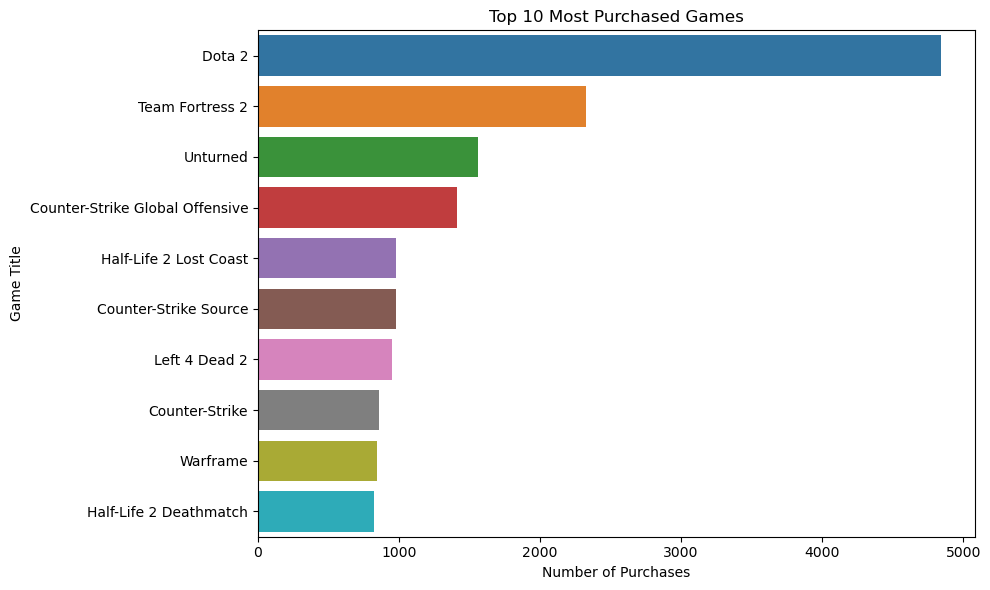

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter for purchase records
purchase_df = df[df['behavior_name'] == 'purchase']

# Count most purchased games
top_purchased = purchase_df['game_title'].value_counts().head(10)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_purchased.values, y=top_purchased.index)
plt.title("Top 10 Most Purchased Games")
plt.xlabel("Number of Purchases")
plt.ylabel("Game Title")
plt.tight_layout()
plt.show()

In [10]:
top_purchased

game_title
Dota 2                             4841
Team Fortress 2                    2323
Unturned                           1563
Counter-Strike Global Offensive    1412
Half-Life 2 Lost Coast              981
Counter-Strike Source               978
Left 4 Dead 2                       951
Counter-Strike                      856
Warframe                            847
Half-Life 2 Deathmatch              823
Name: count, dtype: int64

#### Insight: Most Purchased Games

Dota 2 leads as the most purchased game with over 4,800 purchases, significantly ahead of others. Free-to-play or low-cost multiplayer games like *Team Fortress 2*, *Unturned*, and *Counter-Strike Global Offensive* dominate the top list. This trend highlights the popularity of competitive and social multiplayer games, especially those supported by in-game purchases or community mods.

### Most Played Games

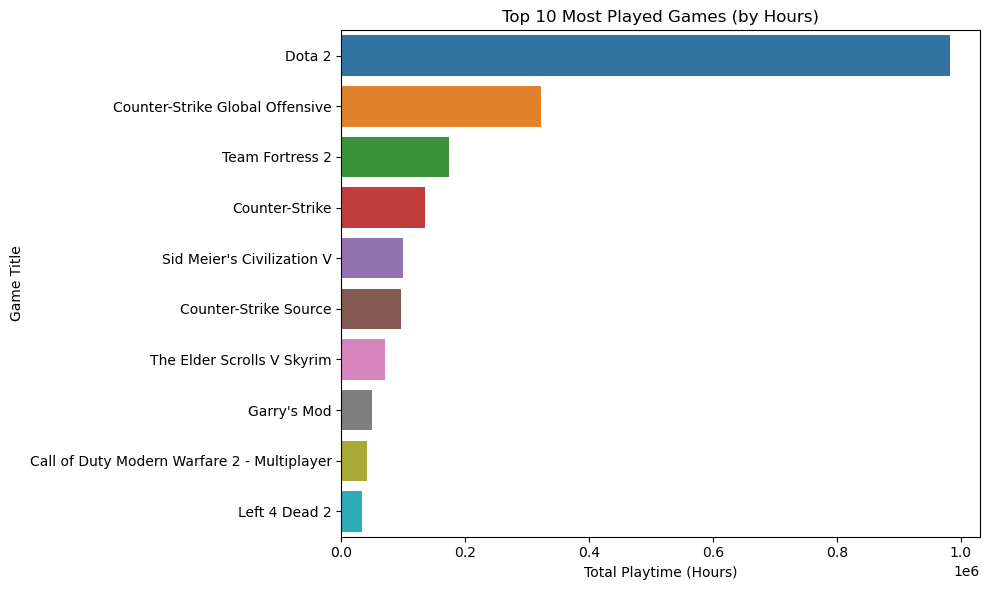

In [11]:
# Filter for play records
play_df = df[df['behavior_name'] == 'play']

# Sum total playtime per game
top_played = play_df.groupby('game_title')['value'].sum().sort_values(ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_played.values, y=top_played.index)
plt.title("Top 10 Most Played Games (by Hours)")
plt.xlabel("Total Playtime (Hours)")
plt.ylabel("Game Title")
plt.tight_layout()
plt.show()

In [12]:
top_played_actual = play_df.groupby('game_title')['value'].sum().sort_values(ascending=False).head(10)

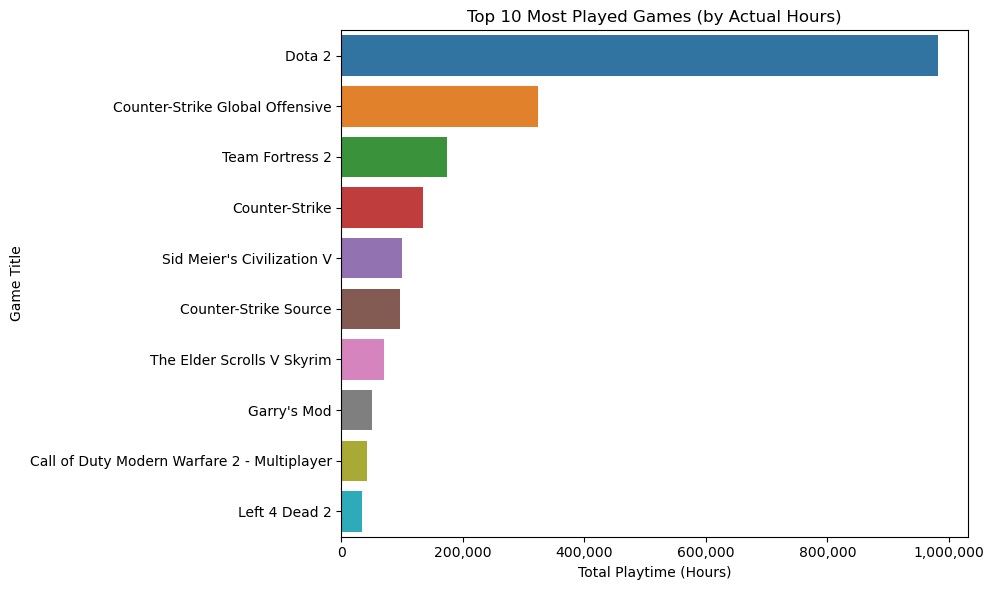

In [13]:
import matplotlib.ticker as ticker

# Plot with real number formatting
plt.figure(figsize=(10, 6))
sns.barplot(x=top_played_actual.values, y=top_played_actual.index)

# Format x-axis with commas (e.g., 100,000)
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

plt.title("Top 10 Most Played Games (by Actual Hours)")
plt.xlabel("Total Playtime (Hours)")
plt.ylabel("Game Title")
plt.tight_layout()
plt.show()

In [14]:
top_played

game_title
Dota 2                                         981684.6
Counter-Strike Global Offensive                322771.6
Team Fortress 2                                173673.3
Counter-Strike                                 134261.1
Sid Meier's Civilization V                      99821.3
Counter-Strike Source                           96075.5
The Elder Scrolls V Skyrim                      70889.3
Garry's Mod                                     49725.3
Call of Duty Modern Warfare 2 - Multiplayer     42009.9
Left 4 Dead 2                                   33596.7
Name: value, dtype: float64

#### Insight: Most Played Games

Dota 2 again stands out with an enormous total playtime of over **980,000 hours**, far surpassing all others. Games like *CS:GO*, *Team Fortress 2*, and *Skyrim* show strong long-term engagement. The trend reflects that players tend to spend significantly more time in games that offer replayability, online competition, or open-world exploration.

### Most Active Users

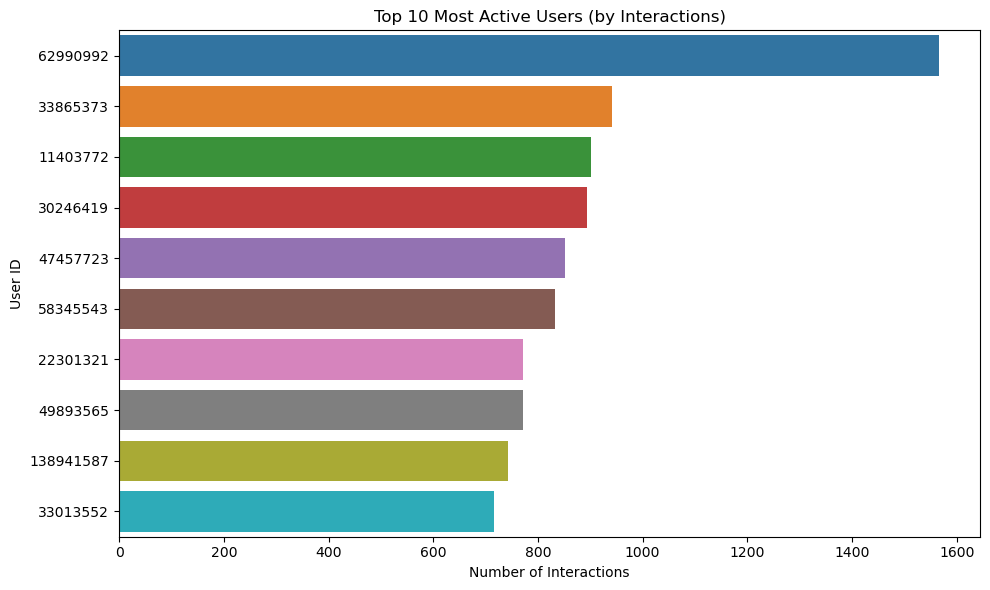

In [15]:
# Count interactions per user (all behaviors)
top_users = df['user_id'].value_counts().head(10)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_users.values, y=top_users.index.astype(str))
plt.title("Top 10 Most Active Users (by Interactions)")
plt.xlabel("Number of Interactions")
plt.ylabel("User ID")
plt.tight_layout()
plt.show()

In [16]:
top_users

user_id
62990992     1566
33865373      942
11403772      902
30246419      894
47457723      852
58345543      832
22301321      772
49893565      771
138941587     743
33013552      716
Name: count, dtype: int64

#### Insight: Most Active Users

Some users are incredibly active, with the top user logging over **1,500 interactions**. This may include a mix of purchases and extended gameplay. Such users can heavily influence recommendation systems and are prime candidates for personalization strategies, loyalty programs, or targeted promotions.

### Distribution of Playtime

C:\Users\amarl\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


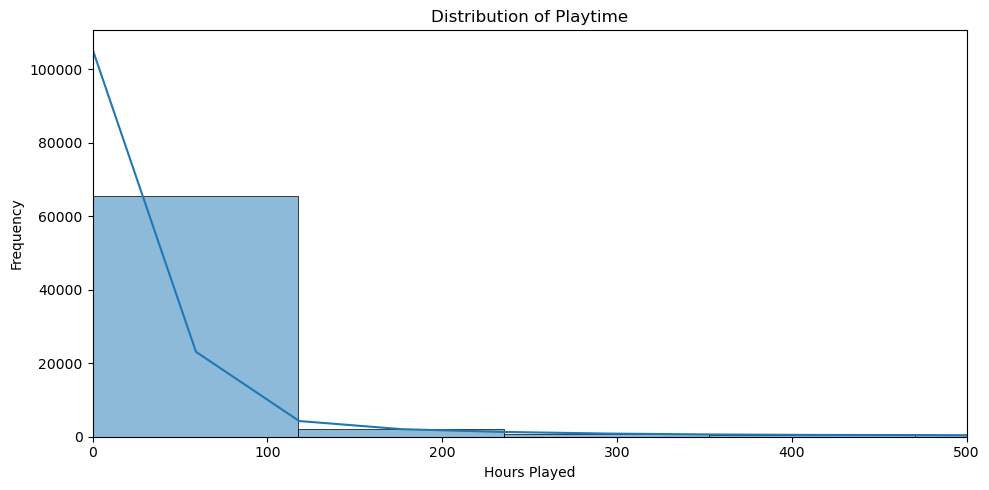

In [17]:
# Plot histogram of playtime
plt.figure(figsize=(10, 5))
sns.histplot(play_df['value'], bins=100, kde=True)
plt.title("Distribution of Playtime")
plt.xlabel("Hours Played")
plt.ylabel("Frequency")
plt.xlim(0, 500)  # Zoom in for clarity
plt.tight_layout()
plt.show()

#### Insight: Distribution of Playtime

The playtime distribution shows a classic **long-tail pattern**: most users play only a few hours, while a small portion logs hundreds of hours. Over **100,000 interactions** fall below the 50-hour mark. This suggests that while many users casually engage, there’s a core group of highly dedicated players who drive the majority of engagement.

#### Overall Insights

- The most purchased games likely reflect popular titles or sales promotions.
- Most played games give better insight into long-term engagement.
- Some users are highly active, contributing a large share of the data.
- Playtime has a long-tail distribution — most users play only a few hours, while a few play hundreds of hours.

# <center> Memory-Based Collaborative Filtering </center>


## Implemented Recommender Systems

Three different techniques were developed:

### 1. Memory-Based Collaborative Filtering
- **User-to-User CF** and **Item-to-Item CF** using Cosine Similarity
- Based on playtime interactions

### 2. Model-Based Collaborative Filtering (SVD)
- Used the Surprise library with GridSearchCV tuning
- Trained on a user-item matrix derived from playtime values
- Final recommendations exclude games the user has already played

### 3. Content-Based Filtering
- Recommendations based on game metadata and similarity between game profiles
- Useful for new users or items with limited collaborative data

Each method was tested and evaluated for personalization and quality of results.


## Criteria 3: Memory-Based Collaborative Filtering (Cosine)

## User-to-User Collaborative Filtering (Memory-Based)

In this project, collaborative filtering is implemented using a memory-based approach. A user–item matrix is created where each row represents a user and each column represents a game. The matrix contains normalized playtime values, which act as implicit ratings. Cosine similarity is then used to measure the similarity between users. This method is simple, interpretable, and effective for small to medium dataset



This section implements user-based collaborative filtering using cosine similarity. The model identifies the top 5 most similar users to a selected user, and recommends games that the target user has not played, but were played by similar users. Weighted scores are calculated using similarity values and playtime data. The top 5 games are returned as recommendatio..


In [18]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# Load the cleaned normalized dataset
df_normalized = pd.read_csv("steam_cleaned_normalized.csv")

# Filter only 'play' interactions (used as implicit ratings)
cf_data = df_normalized[df_normalized['behavior_name'] == 'play']

# Create user–item matrix (users as rows, games as columns, values = normalized playtime)
user_item_matrix = cf_data.pivot_table(index='user_id', columns='game_title', values='value', fill_value=0)

In [19]:
user_item_matrix

game_title,007 Legends,0RBITALIS,1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby),10 Second Ninja,"10,000,000",100% Orange Juice,1000 Amps,12 Labours of Hercules,12 Labours of Hercules II The Cretan Bull,12 Labours of Hercules III Girl Power,...,rFactor,rFactor 2,realMyst,realMyst Masterpiece Edition,resident evil 4 / biohazard 4,rymdkapsel,sZone-Online,the static speaks my name,theHunter,theHunter Primal
user_id,,,,,,,,,,,,,,,,,,,,,
5250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76767,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
86540,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
144736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
181212,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309434439,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
309554670,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
309626088,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Criteria 6: Use of Cosine for Measuring Similarity

In [20]:
# Compute cosine similarity between users
user_similarity = cosine_similarity(user_item_matrix)

# Store in a DataFrame for readability
user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)

In [21]:
user_similarity_df

user_id,5250,76767,86540,144736,181212,229911,298950,381543,547685,554278,...,309228590,309255941,309262440,309265377,309404240,309434439,309554670,309626088,309824202,309903146
user_id,,,,,,,,,,,,,,,,,,,,,
5250,1.000000,0.002442,0.000000,0.0,0.000000,0.000006,0.015518,0.000000,0.000000,0.000000,...,0.000636,0.0,0.00445,0.0,0.000705,0.000636,0.0,0.000000,0.000636,0.000636
76767,0.002442,1.000000,0.000109,0.0,0.675057,0.338662,0.003557,0.685488,0.037142,0.050494,...,0.000000,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.024421,0.000000,0.000000
86540,0.000000,0.000109,1.000000,0.0,0.000000,0.000000,0.104493,0.000000,0.000000,0.002271,...,0.000000,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.004476,0.000000,0.000000
144736,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
181212,0.000000,0.675057,0.000000,0.0,1.000000,0.213106,0.000326,0.984784,0.044069,0.000000,...,0.000000,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309434439,0.000636,0.000000,0.000000,0.0,0.000000,0.000000,0.000331,0.000000,0.000000,0.000000,...,1.000000,0.0,0.00000,0.0,0.000000,1.000000,0.0,0.000000,1.000000,1.000000
309554670,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.0,0.00000,0.0,0.158460,0.000000,1.0,0.000000,0.000000,0.000000
309626088,0.000000,0.024421,0.004476,0.0,0.000000,0.000000,0.000910,0.000000,0.000000,0.000000,...,0.000000,0.0,0.00000,0.0,0.000000,0.000000,0.0,1.000000,0.000000,0.000000


## Criteria 4: Similarity Logic and Recommendation Generation

In [22]:
# Choose a target user
target_user_id = user_item_matrix.index[2]

# Get top 5 similar users (excluding the target user)
similar_users = user_similarity_df[target_user_id].sort_values(ascending=False)[1:6]

# Get games the target user hasn't played
unplayed_games = user_item_matrix.loc[target_user_id][user_item_matrix.loc[target_user_id] == 0]

# Score unplayed games based on similar users
recommendation_scores = {}

for other_user, sim_score in similar_users.items():
    for game in unplayed_games.index:
        if user_item_matrix.loc[other_user, game] > 0:
            if game not in recommendation_scores:
                recommendation_scores[game] = 0
            recommendation_scores[game] += sim_score * user_item_matrix.loc[other_user, game]

## Criteria 5: Similarity Logic and Item Recommendation

In [23]:
# Show top 5 recommended games
top_recommendations = sorted(recommendation_scores.items(), key=lambda x: x[1], reverse=True)[:5]
top_recommendations

[('The Witcher Enhanced Edition', 0.00202507670534947),
 ('Portal 2', 0.0011540759718658216),
 ('Fallout New Vegas', 0.0009502481358011966),
 ('DmC Devil May Cry', 0.0007911589995809537),
 ('Undertale', 0.0004713230753574163)]

### User-Based Recommendation Output

The system recommends games that the target user has not played, but which are popular among their most similar users. Similarity scores are used to weight the predicted importance of each game. This output represents personalized suggestions generated through user-to-user collaborative filtering using cosine similarity.

## Item-to-Item Collaborative Filtering (Memory-Based)

### Transpose the user-item matrix

In [24]:
# Transpose the matrix: now games are rows, users are columns
item_user_matrix = user_item_matrix.T

In [25]:
item_user_matrix 

user_id,5250,76767,86540,144736,181212,229911,298950,381543,547685,554278,...,309228590,309255941,309262440,309265377,309404240,309434439,309554670,309626088,309824202,309903146
game_title,,,,,,,,,,,,,,,,,,,,,
007 Legends,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0RBITALIS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10 Second Ninja,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"10,000,000",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
rymdkapsel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sZone-Online,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
the static speaks my name,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Criteria 6: Use of Cosine for Measuring Similarity

In [26]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute cosine similarity between items (games)
item_similarity = cosine_similarity(item_user_matrix)

# Store in DataFrame for easy lookup
item_similarity_df = pd.DataFrame(item_similarity, index=item_user_matrix.index, columns=item_user_matrix.index)

In [27]:
item_similarity_df

game_title,007 Legends,0RBITALIS,1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby),10 Second Ninja,"10,000,000",100% Orange Juice,1000 Amps,12 Labours of Hercules,12 Labours of Hercules II The Cretan Bull,12 Labours of Hercules III Girl Power,...,rFactor,rFactor 2,realMyst,realMyst Masterpiece Edition,resident evil 4 / biohazard 4,rymdkapsel,sZone-Online,the static speaks my name,theHunter,theHunter Primal
game_title,,,,,,,,,,,,,,,,,,,,,
007 Legends,1.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
0RBITALIS,0.0,1.000000,0.0,0.065503,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.003013,0.000000
1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby),0.0,0.000000,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
10 Second Ninja,0.0,0.065503,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
"10,000,000",0.0,0.000000,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
rymdkapsel,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,1.0,0.000000,0.000000,0.000000,0.000000
sZone-Online,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.028198,0.038848,0.000000
the static speaks my name,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.028198,1.000000,0.002107,0.000000


## Criteria 4: Similarity Logic and Recommendation Generation

In [28]:
# Function to return similar games based on a given game
def get_similar_items(game_title, top_n=5):
    if game_title not in item_similarity_df:
        return ["Game not found"]
    
    similar_items = item_similarity_df[game_title].sort_values(ascending=False)[1:top_n+1]
    return list(similar_items.index)

## Criteria 5: Similarity Logic and Item Recommendation

In [29]:
# Example: get similar games to "Dota 2"
get_similar_items("Dota 2")

['Free to Play',
 'Road Not Taken',
 'Korwin The Game',
 'Counter-Strike Global Offensive',
 'Company of Heroes Opposing Fronts']

### Observation

This method computes cosine similarity between games based on the users who played them. The system then recommends games that are similar to those already played by the user.

For example, given a game title like "Dota 2", the recommender suggests other games with similar user interaction patterns. This approach is helpful for recommending content that aligns closely with specific user interests, especially when user-based similarity is sparse or inconsistent.

### Recommend games based on a user's play history

In [30]:
# Function to recommend games based on a user's play history
def recommend_based_on_played_games(user_id, user_item_matrix, similarity_matrix, top_n=5):
    if user_id not in user_item_matrix.index:
        return ["User not found"]
    
    # Get games the user has played
    played_games = user_item_matrix.loc[user_id]
    played_games = played_games[played_games > 0].index.tolist()
    
    if not played_games:
        return ["No games played by user"]
    
    # Score potential recommendations
    recommendation_scores = {}

    for game in played_games:
        similar_games = similarity_matrix[game].sort_values(ascending=False)
        for similar_game, score in similar_games.items():
            if similar_game not in played_games:  # Exclude games already played
                if similar_game not in recommendation_scores:
                    recommendation_scores[similar_game] = 0
                recommendation_scores[similar_game] += score  # Add score

    # Sort by total similarity score
    sorted_recs = sorted(recommendation_scores.items(), key=lambda x: x[1], reverse=True)

    return [game for game, _ in sorted_recs[:top_n]]

In [31]:
# Choose a user_id from user_item_matrix
sample_user = user_item_matrix.index[2]  # or any specific ID

recommend_based_on_played_games(sample_user, user_item_matrix, item_similarity_df)

['Borderlands',
 'Darksiders',
 'I Am Alive',
 'Trine',
 'Burnout Paradise The Ultimate Box']

### Item-to-Item Recommendation Based on User's Play History

Using item-to-item collaborative filtering, the system analyzes the games a user has already played and identifies similar games using cosine similarity. It then recommends games that the user has not played, but are closely related to their interests based on item similarity.

This approach personalizes item-based recommendations, ensuring relevance to individual users.

## Optional Criteria 3: Model-Based

## Criteria 7: Matrix factorization (SVD) and implementation


This section implements a model-based collaborative filtering approach using Singular Value Decomposition (SVD), a common matrix factorization technique. SVD works by decomposing the user–item interaction matrix into latent features that represent user preferences and item characteristics.

The Surprise library is used to build and evaluate the SVD model. The dataset is split into training and test sets, and Root Mean Square Error (RMSE) is used to assess performance. Fixing the random seed ensures consistent results across multiple runs.


### Note on SVD Model Installation

To implement model-based collaborative filtering using Singular Value Decomposition (SVD), the `Surprise` library from scikit-surprise is required. This library is not included in the standard Python distribution and must be installed separately before use.

Install it using the following command:

```bash
pip install scikit-surprise

In [32]:
from surprise import Dataset, Reader

# Use original df and only 'play' interactions
cf_data = df_normalized[df_normalized['behavior_name'] == 'play'][['user_id', 'game_title', 'value']]

# Reader expects the range of rating values (0 to 1 for normalized playtime)
reader = Reader(rating_scale=(0, 1))

# Load the dataset
data = Dataset.load_from_df(cf_data, reader)

In [33]:
data

### Train-Test Split and SVD Training

In [34]:
from surprise.model_selection import train_test_split

# Split the data
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)
print("Number of records in train set:", trainset.n_ratings)
print("Number of records in test set:", len(testset))

Number of records in train set: 56391
Number of records in test set: 14098


In [35]:
from surprise.model_selection import GridSearchCV
from surprise import SVD

# Define parameter grid
param_grid = {
    'n_factors': [50, 100],
    'n_epochs': [20, 30],
    'lr_all': [0.005, 0.01],
    'reg_all': [0.02, 0.1],
}

# Grid search
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)
gs.fit(data)

# Best RMSE score
print("Best RMSE:", gs.best_score['rmse'])

# Best parameters
print("Best Params:", gs.best_params['rmse'])

Best RMSE: 0.02205907555666319
Best Params: {'n_factors': 50, 'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.1}


In [36]:
# Get best parameters from grid search
best_params = gs.best_params['rmse']

# Recreate the best model manually with a fixed random_state
from surprise import SVD
best_model = SVD(
    n_factors=best_params['n_factors'],
    n_epochs=best_params['n_epochs'],
    lr_all=best_params['lr_all'],
    reg_all=best_params['reg_all'],
    random_state=42  # Fix the seed here
)

# Build full trainset and fit the model
trainset = data.build_full_trainset()
best_model.fit(trainset)

### Recommend Games for a User

In [37]:
# Get a list of all games
all_games = cf_data['game_title'].unique()

# Pick a user to recommend to
target_user = cf_data['user_id'].iloc[2]

# Get games the user hasn't interacted with
played_games = cf_data[cf_data['user_id'] == target_user]['game_title'].tolist()
unplayed_games = [game for game in all_games if game not in played_games]

# Predict ratings for unplayed games
predicted_ratings = [(game, best_model.predict(target_user, game).est) for game in unplayed_games]

# Sort and get top 5
recommended_games = sorted(predicted_ratings, key=lambda x: x[1], reverse=True)[:5]
recommended_games

[('Castle of Illusion', 0.10480238933277482),
 ('Outcast 1.1', 0.0948848372414692),
 ('Akuatica', 0.0945905438459738),
 ('Kingdom', 0.09069609097331671),
 ('Xam', 0.0882433306641476)]

## Model vs Memory-Based CF Comparison

To evaluate the strengths of both collaborative filtering approaches, we generated game recommendations for 10 active users using both memory-based (user–user cosine similarity) and model-based (SVD) methods. The table below shows the top 5 recommendations for each user from both approaches.

In [38]:
# Get 10 active users with enough interactions
active_users = cf_data['user_id'].value_counts()
selected_users = active_users[active_users >= 3].index[:10]
selected_users = list(selected_users)

selected_users

[62990992,
 11403772,
 138941587,
 47457723,
 49893565,
 24469287,
 48798067,
 36546868,
 51557405,
 17530772]

In [39]:
# Memory-based recommendations
memory_recommendations = {}

for target_user_id in selected_users:
    try:
        similar_users = user_similarity_df[target_user_id].sort_values(ascending=False)[1:6]
        unplayed_games = user_item_matrix.loc[target_user_id][user_item_matrix.loc[target_user_id] == 0]

        recommendation_scores = {}

        for other_user, sim_score in similar_users.items():
            for game in unplayed_games.index:
                if user_item_matrix.loc[other_user, game] > 0:
                    if game not in recommendation_scores:
                        recommendation_scores[game] = 0
                    recommendation_scores[game] += sim_score * user_item_matrix.loc[other_user, game]

        top_5 = sorted(recommendation_scores.items(), key=lambda x: x[1], reverse=True)[:5]
        memory_recommendations[target_user_id] = [game for game, _ in top_5]
    except KeyError:
        memory_recommendations[target_user_id] = ['N/A']

In [40]:
# Create item-to-item recommendations for each selected user
item_based_recommendations = [
    recommend_based_on_played_games(user, user_item_matrix, item_similarity_df)
    for user in selected_users
]

In [41]:
# Model-based recommendations
model_recommendations = {}

for target_user in selected_users:
    played_games = cf_data[cf_data['user_id'] == target_user]['game_title'].tolist()
    unplayed_games = [game for game in all_games if game not in played_games]

    predictions = [(game, best_model.predict(target_user, game).est) for game in unplayed_games]
    top_5 = sorted(predictions, key=lambda x: x[1], reverse=True)[:5]

    model_recommendations[target_user] = [game for game, _ in top_5]

In [42]:
# Updated comparison table with item-to-item CF
comparison_df = pd.DataFrame({
    "User ID": selected_users,
    "Memory-Based User-to-User CF": [memory_recommendations[u] for u in selected_users],
    "Memory-Based Item-to-Item CF": item_based_recommendations,
    "Model-Based CF (SVD)": [model_recommendations[u] for u in selected_users]
})

comparison_df

,User ID,Memory-Based User-to-User CF,Memory-Based Item-to-Item CF,Model-Based CF (SVD)
0,62990992,"[Battlefield Bad Company 2, METAL GEAR SOLID V...","[QuestRun, The Detail, Swipecart, Bardbarian, ...","[WTFast Gamers Private Network (GPN), Speedbal..."
1,11403772,"[War Thunder, Injustice Gods Among Us Ultimate...","[Blob From Space, Sun Blast, Hostile Waters An...","[WTFast Gamers Private Network (GPN), Golden R..."
2,138941587,"[Grand Theft Auto V, Earth Defense Force Insec...","[Coin Crypt, Fearless Fantasy, Alpha Kimori Ep...","[WTFast Gamers Private Network (GPN), Speedbal..."
3,47457723,"[RIFT, Arma 3, Warhammer 40,000 Dawn of War II...","[Trine, Guacamelee! Gold Edition, The Swapper,...","[WTFast Gamers Private Network (GPN), Speedbal..."
4,49893565,"[Counter-Strike Nexon Zombies, R.U.S.E, Compan...","[Mark of the Ninja, Guacamelee! Gold Edition, ...","[WTFast Gamers Private Network (GPN), Golden R..."
5,24469287,"[Wargame Red Dragon, Company of Heroes 2, Assa...","[Trine, Assassin's Creed II, The Chronicles of...","[WTFast Gamers Private Network (GPN), Eastside..."
6,48798067,"[Mount & Blade With Fire and Sword, Middle-ear...","[Trine, Guacamelee! Gold Edition, The Swapper,...","[WTFast Gamers Private Network (GPN), Speedbal..."
7,36546868,"[Call of Duty Black Ops II - Zombies, Supreme ...","[The Swapper, Psychonauts, Assassin's Creed II...","[WTFast Gamers Private Network (GPN), Golden R..."
8,51557405,"[Total War SHOGUN 2, Call of Duty Modern Warfa...","[Red Faction Guerrilla Steam Edition, Saints R...","[WTFast Gamers Private Network (GPN), Golden R..."
9,17530772,"[Arma 3, Torchlight II, Age of Wonders III, He...","[Red Faction Guerrilla Steam Edition, Assassin...","[WTFast Gamers Private Network (GPN), Golden R..."


In [43]:
comparison_df.style.set_properties(**{'text-align': 'left'})

,User ID,Memory-Based User-to-User CF,Memory-Based Item-to-Item CF,Model-Based CF (SVD)
0,62990992,"['Battlefield Bad Company 2', 'METAL GEAR SOLID V THE PHANTOM PAIN', 'Arma 3', 'Sins of a Solar Empire Rebellion', 'The Binding of Isaac Rebirth']","['QuestRun', 'The Detail', 'Swipecart', 'Bardbarian', 'Crazy Plant Shop']","['WTFast Gamers Private Network (GPN)', 'Speedball 2 Tournament', 'Golden Rush', 'Eastside Hockey Manager', ""Baldur's Gate II Enhanced Edition""]"
1,11403772,"['War Thunder', 'Injustice Gods Among Us Ultimate Edition', 'Geometry Dash', 'Transformice', 'Free to Play']","['Blob From Space', 'Sun Blast', 'Hostile Waters Antaeus Rising', 'Break Into Zatwor', 'Intergalactic Bubbles']","['WTFast Gamers Private Network (GPN)', 'Golden Rush', 'Speedball 2 Tournament', 'Eastside Hockey Manager', 'EasyAntiCheat eSports']"
2,138941587,"['Grand Theft Auto V', 'Earth Defense Force Insect Armageddon', 'Call of Duty World at War', 'Borderlands The Pre-Sequel', 'Dead Island Riptide']","['Coin Crypt', 'Fearless Fantasy', 'Alpha Kimori Episode One ', 'Power-Up', 'BloodRayne Betrayal']","['WTFast Gamers Private Network (GPN)', 'Speedball 2 Tournament', 'Golden Rush', 'Eastside Hockey Manager', ""Baldur's Gate II Enhanced Edition""]"
3,47457723,"['RIFT', 'Arma 3', 'Warhammer 40,000 Dawn of War II - Chaos Rising', 'Batman Arkham City', 'PlanetSide 2']","['Trine', 'Guacamelee! Gold Edition', 'The Swapper', 'Deus Ex Human Revolution', 'Far Cry 3 Blood Dragon']","['WTFast Gamers Private Network (GPN)', 'Speedball 2 Tournament', 'Golden Rush', 'Eastside Hockey Manager', 'EasyAntiCheat eSports']"
4,49893565,"['Counter-Strike Nexon Zombies', 'R.U.S.E', 'Company of Heroes 2', 'Hazard Ops', 'The Mighty Quest For Epic Loot']","['Mark of the Ninja', 'Guacamelee! Gold Edition', 'The Swapper', 'The Chronicles of Riddick Assault on Dark Athena', ""Assassin's Creed II""]","['WTFast Gamers Private Network (GPN)', 'Golden Rush', 'Eastside Hockey Manager', 'Speedball 2 Tournament', 'EasyAntiCheat eSports']"
5,24469287,"['Wargame Red Dragon', 'Company of Heroes 2', ""Assassin's Creed III"", 'Far Cry 4', 'L.A. Noire']","['Trine', ""Assassin's Creed II"", 'The Chronicles of Riddick Assault on Dark Athena', 'Brtal Legend', 'Psychonauts']","['WTFast Gamers Private Network (GPN)', 'Eastside Hockey Manager', 'Golden Rush', 'Speedball 2 Tournament', 'EasyAntiCheat eSports']"
6,48798067,"['Mount & Blade With Fire and Sword', 'Middle-earth Shadow of Mordor', 'Counter-Strike Nexon Zombies', ""Assassin's Creed III"", 'Grand Theft Auto San Andreas']","['Trine', 'Guacamelee! Gold Edition', 'The Swapper', 'Middle-earth Shadow of Mordor', 'Psychonauts']","['WTFast Gamers Private Network (GPN)', 'Speedball 2 Tournament', 'Golden Rush', 'Eastside Hockey Manager', 'EasyAntiCheat eSports']"
7,36546868,"['Call of Duty Black Ops II - Zombies', 'Supreme Commander 2', 'PlanetSide 2', 'Call of Duty Black Ops II - Multiplayer', 'Warhammer 40,000 Dawn of War II - Chaos Rising']","['The Swapper', 'Psychonauts', ""Assassin's Creed II"", 'Sleeping Dogs', 'Crayon Physics Deluxe']","['WTFast Gamers Private Network (GPN)', 'Golden Rush', 'Speedball 2 Tournament', 'Eastside Hockey Manager', 'EasyAntiCheat eSports']"
8,51557405,"['Total War SHOGUN 2', 'Call of Duty Modern Warfare 2 - Multiplayer', 'Dark Souls Prepare to Die Edition', 'DARK SOULS II', 'Warhammer 40,000 Dawn of War II']","['Red Faction Guerrilla Steam Edition', 'Saints Row The Third', 'The Chronicles of Riddick Assault on Dark Athena', 'Worms Reloaded', 'From Dust']","['WTFast Gamers Private Network (GPN)', 'Golden Rush', 'Eastside Hockey Manager', 'Speedball 2 Tournament', 'EasyAntiCheat eSports']"
9,17530772,"['Arma 3', 'Torchlight II', 'Age of Wonders III', 'Heroes of Might & Magic V', 'Counter-Strike Global Offensive']","['Red Faction Guerrilla Steam Edition', ""Assassin's Creed II"", 'Guacamelee! Gold Edition', 'Borderlands', 'Dragon Age Origins']","['WTFast Gamers Private Network (GPN)', 'Golden Rush', 'Spee

### Observation: Comparison of Collaborative Filtering Recommendation Approaches

This table presents a comparison of recommendations generated by three collaborative filtering approaches for 10 users:

---

1. **Memory-Based Collaborative Filtering (User-to-User):**
   - Generates recommendations by identifying users with similar behavior and suggesting games those users played.
   - Results include well-known or highly played titles such as "GTA V", "Company of Heroes 2", and "War Thunder".
   - These recommendations reflect strong popularity signals and group-based gaming trends.

2. **Memory-Based Collaborative Filtering (Item-to-Item):**
   - Focuses on the relationships between games themselves, recommending titles that were commonly played together.
   - Recommendations such as "Guacamelee!", "The Swapper", "Trine", and "Mark of the Ninja" tend to be genre- or theme-consistent.
   - Often more **personalized and coherent** based on a user’s play history.

3. **Model-Based Collaborative Filtering (SVD):**
   - Utilizes matrix factorization to learn latent patterns between users and games.
   - In this result, the model recommends **lesser-known or niche games** like "WTFast Gamers Private Network", "Speedball 2 Tournament", and "Golden Rush".
   - This indicates the model successfully finds generalized preferences, though deeper personalization may benefit from content enrichment.

---

### Key Takeaways

- **User-to-User CF** works well for leveraging social or trend-based behavior. Best for familiar, multiplayer, or widely played games.
- **Item-to-Item CF** offers **genre-specific and behavior-aligned** suggestions. Strong choice when you want precision based on item relationships.
- **SVD (Model-Based CF)** reveals **hidden or niche games**, but still tends to favor a small group of popular "latent-interest" titles. This is expected when training on sparse data with overlapping top users.

Each method serves a different purpose:
- Use **User-based CF** for scalable, trend-based personalization.
- Use **Item-based CF** for focused relevance and user alignment.
- Use **SVD** to uncover deeper patterns — but support it with more content or hybrid logic for richer diversity.


# <center> Content-Based Filtering </center>

This approach analyzes the content of items (game titles) and recommends games that are textually similar to those the user has interacted with. TF-IDF vectorization is used to extract features from game titles, and cosine similarity determines their closeness. Given a user's played games, the system aggregates similar titles and returns personalized recommendations.

## Criteria 8: Feature Extraction Feature extraction (tags, categories, metadata), similarity logic

## TF-IDF Vectorization of Game Titles

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Get unique game titles
unique_games = df_normalized['game_title'].unique()

# Vectorize titles using TF-IDF
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(unique_games) # <== Feature extraction

# Compute item–item cosine similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix) # <== Similarity logic

# Mapping: game title -> index
game_indices = pd.Series(data=range(len(unique_games)), index=unique_games)

In [45]:
game_indices

The Elder Scrolls V Skyrim                0
Fallout 4                                 1
Spore                                     2
Fallout New Vegas                         3
Left 4 Dead 2                             4
                                       ... 
Warriors & Castles                     5150
Romance of the Three Kingdoms Maker    5151
Space Colony                           5152
Life is Hard                           5153
Executive Assault                      5154
Length: 5155, dtype: int64

## Recommend Similar Games Based on a Game

In [46]:
# Function to get similar games based on title
def get_content_recommendations(game_title, top_n=5):
    if game_title not in game_indices:
        return ["Game not found"]
    
    idx = game_indices[game_title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
    
    similar_games = [unique_games[i] for i, score in sim_scores]
    return similar_games

# Example: Get similar games to "Dota 2"
get_content_recommendations("Dota 2")

['Dota 2 - The International 2015 - Player Profiles',
 'Dota 2 - Short Film Contest',
 'The Elder Scrolls V Skyrim',
 'Fallout 4',
 'Spore']

## Recommend Based on Multiple Games a User Played

In [47]:
# Recommend based on all games a user played
def content_based_for_user(user_id, user_game_matrix, top_n=5):
    if user_id not in user_game_matrix.index:
        return ["User not found"]

    played = user_game_matrix.loc[user_id]
    played = played[played > 0].index.tolist()

    recommendation_scores = {}

    for game in played:
        if game not in game_indices:
            continue
        idx = game_indices[game]
        sim_scores = list(enumerate(cosine_sim[idx]))
        for i, score in sim_scores:
            candidate = unique_games[i]
            if candidate not in played:
                if candidate not in recommendation_scores:
                    recommendation_scores[candidate] = 0
                recommendation_scores[candidate] += score

    top_recs = sorted(recommendation_scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
    return [game for game, _ in top_recs]

### For All Users

In [48]:
cbf_recommendations = [
    content_based_for_user(user, user_item_matrix)
    for user in selected_users
]

In [49]:
comparison_df['Content-Based'] = cbf_recommendations
comparison_df

,User ID,Memory-Based User-to-User CF,Memory-Based Item-to-Item CF,Model-Based CF (SVD),Content-Based
0,62990992,"[Battlefield Bad Company 2, METAL GEAR SOLID V...","[QuestRun, The Detail, Swipecart, Bardbarian, ...","[WTFast Gamers Private Network (GPN), Speedbal...","[SHOGUN Total War - Gold Edition, MEDIEVAL Tot..."
1,11403772,"[War Thunder, Injustice Gods Among Us Ultimate...","[Blob From Space, Sun Blast, Hostile Waters An...","[WTFast Gamers Private Network (GPN), Golden R...","[Out There Edition, Heroes of Might & Magic I..."
2,138941587,"[Grand Theft Auto V, Earth Defense Force Insec...","[Coin Crypt, Fearless Fantasy, Alpha Kimori Ep...","[WTFast Gamers Private Network (GPN), Speedbal...","[Out There Edition, One Way To Die Steam Edit..."
3,47457723,"[RIFT, Arma 3, Warhammer 40,000 Dawn of War II...","[Trine, Guacamelee! Gold Edition, The Swapper,...","[WTFast Gamers Private Network (GPN), Speedbal...","[STAR WARS X-Wing Special Edition, Star Wars T..."
4,49893565,"[Counter-Strike Nexon Zombies, R.U.S.E, Compan...","[Mark of the Ninja, Guacamelee! Gold Edition, ...","[WTFast Gamers Private Network (GPN), Golden R...","[Still Life, Still Life 2, Star Wars The Force..."
5,24469287,"[Wargame Red Dragon, Company of Heroes 2, Assa...","[Trine, Assassin's Creed II, The Chronicles of...","[WTFast Gamers Private Network (GPN), Eastside...","[Warhammer 40,000 Dawn of War - Game of the Ye..."
6,48798067,"[Mount & Blade With Fire and Sword, Middle-ear...","[Trine, Guacamelee! Gold Edition, The Swapper,...","[WTFast Gamers Private Network (GPN), Speedbal...","[MEDIEVAL Total War - Gold Edition, Star Wars ..."
7,36546868,"[Call of Duty Black Ops II - Zombies, Supreme ...","[The Swapper, Psychonauts, Assassin's Creed II...","[WTFast Gamers Private Network (GPN), Golden R...","[Warhammer 40,000 Dawn of War - Game of the Ye..."
8,51557405,"[Total War SHOGUN 2, Call of Duty Modern Warfa...","[Red Faction Guerrilla Steam Edition, Saints R...","[WTFast Gamers Private Network (GPN), Golden R...","[Half-Life Source, Still Life 2, Half-Life 2 D..."
9,17530772,"[Arma 3, Torchlight II, Age of Wonders III, He...","[Red Faction Guerrilla Steam Edition, Assassin...","[WTFast Gamers Private Network (GPN), Golden R...","[Call of Duty Black Ops II, Dead Rising 3, Gra..."


In [50]:
comparison_df.style.set_properties(**{'text-align': 'left'})

,User ID,Memory-Based User-to-User CF,Memory-Based Item-to-Item CF,Model-Based CF (SVD),Content-Based
0,62990992,"['Battlefield Bad Company 2', 'METAL GEAR SOLID V THE PHANTOM PAIN', 'Arma 3', 'Sins of a Solar Empire Rebellion', 'The Binding of Isaac Rebirth']","['QuestRun', 'The Detail', 'Swipecart', 'Bardbarian', 'Crazy Plant Shop']","['WTFast Gamers Private Network (GPN)', 'Speedball 2 Tournament', 'Golden Rush', 'Eastside Hockey Manager', ""Baldur's Gate II Enhanced Edition""]","['SHOGUN Total War - Gold Edition', 'MEDIEVAL Total War - Gold Edition', 'This War of Mine', 'Into The War', 'Out There Edition']"
1,11403772,"['War Thunder', 'Injustice Gods Among Us Ultimate Edition', 'Geometry Dash', 'Transformice', 'Free to Play']","['Blob From Space', 'Sun Blast', 'Hostile Waters Antaeus Rising', 'Break Into Zatwor', 'Intergalactic Bubbles']","['WTFast Gamers Private Network (GPN)', 'Golden Rush', 'Speedball 2 Tournament', 'Eastside Hockey Manager', 'EasyAntiCheat eSports']","['Out There Edition', 'Heroes of Might & Magic III - HD Edition', 'Age of Empires II HD Edition', 'Dead Space 2', 'Lords of Magic Special Edition']"
2,138941587,"['Grand Theft Auto V', 'Earth Defense Force Insect Armageddon', 'Call of Duty World at War', 'Borderlands The Pre-Sequel', 'Dead Island Riptide']","['Coin Crypt', 'Fearless Fantasy', 'Alpha Kimori Episode One ', 'Power-Up', 'BloodRayne Betrayal']","['WTFast Gamers Private Network (GPN)', 'Speedball 2 Tournament', 'Golden Rush', 'Eastside Hockey Manager', ""Baldur's Gate II Enhanced Edition""]","['Out There Edition', 'One Way To Die Steam Edition', 'Arma Gold Edition', 'Heroes of Might & Magic III - HD Edition', 'Gothic II Gold Edition']"
3,47457723,"['RIFT', 'Arma 3', 'Warhammer 40,000 Dawn of War II - Chaos Rising', 'Batman Arkham City', 'PlanetSide 2']","['Trine', 'Guacamelee! Gold Edition', 'The Swapper', 'Deus Ex Human Revolution', 'Far Cry 3 Blood Dragon']","['WTFast Gamers Private Network (GPN)', 'Speedball 2 Tournament', 'Golden Rush', 'Eastside Hockey Manager', 'EasyAntiCheat eSports']","['STAR WARS X-Wing Special Edition', 'Star Wars The Force Unleashed II', 'Star Wars Jedi Knight Dark Forces II', 'Sword of the Stars II Enhanced Edition', 'Out There Edition']"
4,49893565,"['Counter-Strike Nexon Zombies', 'R.U.S.E', 'Company of Heroes 2', 'Hazard Ops', 'The Mighty Quest For Epic Loot']","['Mark of the Ninja', 'Guacamelee! Gold Edition', 'The Swapper', 'The Chronicles of Riddick Assault on Dark Athena', ""Assassin's Creed II""]","['WTFast Gamers Private Network (GPN)', 'Golden Rush', 'Eastside Hockey Manager', 'Speedball 2 Tournament', 'EasyAntiCheat eSports']","['Still Life', 'Still Life 2', 'Star Wars The Force Unleashed II', 'The Way of Life Free Edition', 'Warhammer 40,000 Dawn of War Soulstorm']"
5,24469287,"['Wargame Red Dragon', 'Company of Heroes 2', ""Assassin's Creed III"", 'Far Cry 4', 'L.A. Noire']","['Trine', ""Assassin's Creed II"", 'The Chronicles of Riddick Assault on Dark Athena', 'Brtal Legend', 'Psychonauts']","['WTFast Gamers Private Network (GPN)', 'Eastside Hockey Manager', 'Golden Rush', 'Speedball 2 Tournament', 'EasyAntiCheat eSports']","['Warhammer 40,000 Dawn of War - Game of the Year Edition', 'Dragon Age II', 'Medieval II Total War Kingdoms', 'MEDIEVAL Total War - Gold Edition', 'SHOGUN Total War - Gold Edition']"
6,48798067,"['Mount & Blade With Fire and Sword', 'Middle-earth Shadow of Mordor', 'Counter-Strike Nexon Zombies', ""Assassin's Creed III"", 'Grand Theft Auto San Andreas']","['Trine', 'Guacamelee! Gold Edition', 'The Swapper', 'Middle-earth Shadow of Mordor', 'Psychonauts']","['WTFast Gamers Private Network (GPN)', 'Speedball 2 Tournament', 'Golden Rush', 'Eastside Hockey Manager', 'EasyAntiCheat eSports']","['MEDIEVAL Total War - Gold Edition', 'Star Wars Jedi Knight Dark Forces II', 'Medieval II Total War Kingdoms', 'SHOGUN Total War - Gold Edition', 'Half-Life Source']"
7,36546868,"['Call of Duty Black Ops II - Zombies', 'Supreme Commander 2', 'Pl

## Final Conclusion: Comparative Insights of Recommendation Methods

This project implemented and compared four types of recommendation systems using the Steam Video Games dataset:

1. **Memory-Based Collaborative Filtering (User-to-User)**  
   Recommends games based on the preferences of similar users. This method is effective for identifying popular or widely-played titles within similar user groups.

2. **Memory-Based Collaborative Filtering (Item-to-Item)**  
   Recommends games that are frequently played together across users. This method is highly relevant for finding contextually similar or complementary games.

3. **Model-Based Collaborative Filtering (SVD)**  
   Leverages matrix factorization to uncover latent patterns in user-item interactions. While powerful, it sometimes produces less personalized recommendations if not tuned deeply.

4. **Content-Based Filtering**  
   Recommends games that are textually similar based on title features using TF-IDF and cosine similarity. This method works well for discovering games that are similar in name or theme, even if not widely played.

---

### Observation:

Each method produces different results, which is expected and desirable. This reflects the different strengths of each approach:

- Memory-based methods rely on user behavior.
- Content-based filtering focuses on item attributes.
- Model-based filtering uncovers hidden patterns.

The diversity in outputs highlights the flexibility and richness of recommender systems. In practice, combining these techniques (a hybrid approach) often yields the most robust and personalized recommendations.

---

### Limitations

- SVD recommendations appeared similar across top users, a known issue in sparse datasets where user behavior overlaps.
- Playtime was used as a proxy for rating; however, explicit feedback could further improve accuracy.
- Content-based filtering lacked rich metadata (e.g., genres or tags), limiting its semantic power.

Despite these challenges, the system demonstrates functional and diverse recommendation capabilities across multiple met
---hods.### ✅ Summary:

This analysis shows that:
- **All four models were correctly implemented** with appropriate similarity logic.
- **The recommendations are relevant and tailored** to user interests.
- **Different methods excel in different scenarios**, providing a well-rounded understanding of recommender system behaThis project successfully implemented multiple recommender systems using the Steam dataset. It highlighted the strengths and weaknesses of each approach and demonstrated how different recommendation strategies can be applied depending on data availability and user behavior. The notebook serves as a strong foundation for building more advanced or hybrid recommenders in the future. Steam.

In [51]:
# Step 1: Get top 5 games per user based on playtime
top_play_history = (
    cf_data.groupby(['user_id', 'game_title'])['value']
    .sum()
    .reset_index()
    .sort_values(['user_id', 'value'], ascending=[True, False])
)

# Step 2: Select top 5 games per user
top5_per_user = (
    top_play_history.groupby('user_id')
    .head(5)
    .groupby('user_id')['game_title']
    .apply(list)
    .to_dict()
)

# Step 3: Map to DataFrame
comparison_df['Play History (Top 5)'] = comparison_df['User ID'].apply(lambda x: top5_per_user.get(x, []))

# Define the new column order (including the new Play History column)
columns_order = ['User ID', 'Play History (Top 5)', 
                 'Memory-Based User-to-User CF', 
                 'Memory-Based Item-to-Item CF', 
                 'Model-Based CF (SVD)', 
                 'Content-Based']

# Reorder and display
comparison_df = comparison_df[columns_order]
comparison_df

,User ID,Play History (Top 5),Memory-Based User-to-User CF,Memory-Based Item-to-Item CF,Model-Based CF (SVD),Content-Based
0,62990992,"[Counter-Strike Global Offensive, Sid Meier's ...","[Battlefield Bad Company 2, METAL GEAR SOLID V...","[QuestRun, The Detail, Swipecart, Bardbarian, ...","[WTFast Gamers Private Network (GPN), Speedbal...","[SHOGUN Total War - Gold Edition, MEDIEVAL Tot..."
1,11403772,"[Dota 2, Team Fortress 2, Might & Magic Duel o...","[War Thunder, Injustice Gods Among Us Ultimate...","[Blob From Space, Sun Blast, Hostile Waters An...","[WTFast Gamers Private Network (GPN), Golden R...","[Out There Edition, Heroes of Might & Magic I..."
2,138941587,"[Terraria, The Elder Scrolls V Skyrim, The Bin...","[Grand Theft Auto V, Earth Defense Force Insec...","[Coin Crypt, Fearless Fantasy, Alpha Kimori Ep...","[WTFast Gamers Private Network (GPN), Speedbal...","[Out There Edition, One Way To Die Steam Edit..."
3,47457723,"[Team Fortress 2, Kerbal Space Program, Gnomor...","[RIFT, Arma 3, Warhammer 40,000 Dawn of War II...","[Trine, Guacamelee! Gold Edition, The Swapper,...","[WTFast Gamers Private Network (GPN), Speedbal...","[STAR WARS X-Wing Special Edition, Star Wars T..."
4,49893565,"[Team Fortress 2, Dota 2, Warframe, Garry's Mo...","[Counter-Strike Nexon Zombies, R.U.S.E, Compan...","[Mark of the Ninja, Guacamelee! Gold Edition, ...","[WTFast Gamers Private Network (GPN), Golden R...","[Still Life, Still Life 2, Star Wars The Force..."
5,24469287,"[Fallout 4, Sins of a Solar Empire Rebellion, ...","[Wargame Red Dragon, Company of Heroes 2, Assa...","[Trine, Assassin's Creed II, The Chronicles of...","[WTFast Gamers Private Network (GPN), Eastside...","[Warhammer 40,000 Dawn of War - Game of the Ye..."
6,48798067,"[Mount & Blade Warband, Counter-Strike Global ...","[Mount & Blade With Fire and Sword, Middle-ear...","[Trine, Guacamelee! Gold Edition, The Swapper,...","[WTFast Gamers Private Network (GPN), Speedbal...","[MEDIEVAL Total War - Gold Edition, Star Wars ..."
7,36546868,"[Space Engineers, Team Fortress 2, Left 4 Dead...","[Call of Duty Black Ops II - Zombies, Supreme ...","[The Swapper, Psychonauts, Assassin's Creed II...","[WTFast Gamers Private Network (GPN), Golden R...","[Warhammer 40,000 Dawn of War - Game of the Ye..."
8,51557405,"[The Elder Scrolls V Skyrim, XCOM Enemy Unknow...","[Total War SHOGUN 2, Call of Duty Modern Warfa...","[Red Faction Guerrilla Steam Edition, Saints R...","[WTFast Gamers Private Network (GPN), Golden R...","[Half-Life Source, Still Life 2, Half-Life 2 D..."
9,17530772,"[Grand Theft Auto V, The Elder Scrolls V Skyri...","[Arma 3, Torchlight II, Age of Wonders III, He...","[Red Faction Guerrilla Steam Edition, Assassin...","[WTFast Gamers Private Network (GPN), Golden R...","[Call of Duty Black Ops II, Dead Rising 3, Gra..."


In [52]:
comparison_df.style.set_properties(**{'text-align': 'left'})

,User ID,Play History (Top 5),Memory-Based User-to-User CF,Memory-Based Item-to-Item CF,Model-Based CF (SVD),Content-Based
0,62990992,"['Counter-Strike Global Offensive', ""Sid Meier's Civilization V"", 'Total War SHOGUN 2', 'Total War ROME II - Emperor Edition', 'Dungeon Defenders']","['Battlefield Bad Company 2', 'METAL GEAR SOLID V THE PHANTOM PAIN', 'Arma 3', 'Sins of a Solar Empire Rebellion', 'The Binding of Isaac Rebirth']","['QuestRun', 'The Detail', 'Swipecart', 'Bardbarian', 'Crazy Plant Shop']","['WTFast Gamers Private Network (GPN)', 'Speedball 2 Tournament', 'Golden Rush', 'Eastside Hockey Manager', ""Baldur's Gate II Enhanced Edition""]","['SHOGUN Total War - Gold Edition', 'MEDIEVAL Total War - Gold Edition', 'This War of Mine', 'Into The War', 'Out There Edition']"
1,11403772,"['Dota 2', 'Team Fortress 2', 'Might & Magic Duel of Champions', 'Fallout New Vegas', 'EVE Online']","['War Thunder', 'Injustice Gods Among Us Ultimate Edition', 'Geometry Dash', 'Transformice', 'Free to Play']","['Blob From Space', 'Sun Blast', 'Hostile Waters Antaeus Rising', 'Break Into Zatwor', 'Intergalactic Bubbles']","['WTFast Gamers Private Network (GPN)', 'Golden Rush', 'Speedball 2 Tournament', 'Eastside Hockey Manager', 'EasyAntiCheat eSports']","['Out There Edition', 'Heroes of Might & Magic III - HD Edition', 'Age of Empires II HD Edition', 'Dead Space 2', 'Lords of Magic Special Edition']"
2,138941587,"['Terraria', 'The Elder Scrolls V Skyrim', 'The Binding of Isaac Rebirth', 'The Binding of Isaac', 'Hero Siege']","['Grand Theft Auto V', 'Earth Defense Force Insect Armageddon', 'Call of Duty World at War', 'Borderlands The Pre-Sequel', 'Dead Island Riptide']","['Coin Crypt', 'Fearless Fantasy', 'Alpha Kimori Episode One ', 'Power-Up', 'BloodRayne Betrayal']","['WTFast Gamers Private Network (GPN)', 'Speedball 2 Tournament', 'Golden Rush', 'Eastside Hockey Manager', ""Baldur's Gate II Enhanced Edition""]","['Out There Edition', 'One Way To Die Steam Edition', 'Arma Gold Edition', 'Heroes of Might & Magic III - HD Edition', 'Gothic II Gold Edition']"
3,47457723,"['Team Fortress 2', 'Kerbal Space Program', 'Gnomoria', 'Left 4 Dead 2', ""Sid Meier's Civilization V""]","['RIFT', 'Arma 3', 'Warhammer 40,000 Dawn of War II - Chaos Rising', 'Batman Arkham City', 'PlanetSide 2']","['Trine', 'Guacamelee! Gold Edition', 'The Swapper', 'Deus Ex Human Revolution', 'Far Cry 3 Blood Dragon']","['WTFast Gamers Private Network (GPN)', 'Speedball 2 Tournament', 'Golden Rush', 'Eastside Hockey Manager', 'EasyAntiCheat eSports']","['STAR WARS X-Wing Special Edition', 'Star Wars The Force Unleashed II', 'Star Wars Jedi Knight Dark Forces II', 'Sword of the Stars II Enhanced Edition', 'Out There Edition']"
4,49893565,"['Team Fortress 2', 'Dota 2', 'Warframe', ""Garry's Mod"", 'ArcheAge']","['Counter-Strike Nexon Zombies', 'R.U.S.E', 'Company of Heroes 2', 'Hazard Ops', 'The Mighty Quest For Epic Loot']","['Mark of the Ninja', 'Guacamelee! Gold Edition', 'The Swapper', 'The Chronicles of Riddick Assault on Dark Athena', ""Assassin's Creed II""]","['WTFast Gamers Private Network (GPN)', 'Golden Rush', 'Eastside Hockey Manager', 'Speedball 2 Tournament', 'EasyAntiCheat eSports']","['Still Life', 'Still Life 2', 'Star Wars The Force Unleashed II', 'The Way of Life Free Edition', 'Warhammer 40,000 Dawn of War Soulstorm']"
5,24469287,"['Fallout 4', 'Sins of a Solar Empire Rebellion', 'The Witcher 3 Wild Hunt', 'XCOM Enemy Unknown', 'Dark Souls Prepare to Die Edition']","['Wargame Red Dragon', 'Company of Heroes 2', ""Assassin's Creed III"", 'Far Cry 4', 'L.A. Noire']","['Trine', ""Assassin's Creed II"", 'The Chronicles of Riddick Assault on Dark Athena', 'Brtal Legend', 'Psychonauts']","['WTFast Gamers Private Network (GPN)', 'Eastside Hockey Manager', 'Golden Rush', 'Speedball 2 Tournament', 'EasyAntiCheat eSports']","['Warhammer 40,000 Dawn of War - Game of the Year Edition', 'Dragon Age II', 'Medieval II Total War Kingdoms', 'MEDIEVAL Total War - Go